#Forecasting Old School Runescape Item Prices

In this notebook we will use a technique called time series forecasting that predicts a future result. In this instance we are predicting the price of Runescape items. But how can we approach this? 

##Sequential Neural Networks

Sequential networks are a type of neural network that are designed to work with sequential data, such as language and stock prices. In these examples data is heavily influenced by what comes before and or after it. Todays stock prices are heavily influenced by the prices of the days before and in language adjectives and adverbs can greatly modify the meaning of the words preceding.

###Recurent Neural Networks (RNN)

Recurrent neural networks use a feedback network to take in previous data. This means that in a recurrent neural network each neuron can be represented as having 2 outputs, a feed forward, and a feedback. By feeding back previous information into our model we have a network that can learn from both present and previous data.

<img src="https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/rnn-vs-fnn.png">

Recurrent networks also do this thing called unfolding. In the gif shown below we are given an example with a sentence. The word "what" represents our first word and the feedback network modifies everything by a shared weight as it continutes through the sentence until we get to our final word which in this case is "?". We then have a value that we can use for some kind of prediction or that can be fed into another layer of the network.

This presents a big issue, vanishing and exploding gradients. Imagine that we had a sentence or sequence that had 50 words. As we unravel our recurrent layer each value will get multiplied by its weight 50 times. If we had a weight less than 1 our value will be extremely small. Using this value to back-propogate makes it almost impossible to adjust our network since any adjustments will be extremely small. The same applies to values greater than 1 and this results in an exploding gradient, instead of small adjustments we will be left with adjustments that are too large and result in overshoot.

<img src="https://research.aimultiple.com/wp-content/uploads/2021/08/rnn-text.gif">

Despite these problems RNN's can still be functional in tasks such as language however for our price predictions we will be taking in long sequences of data and therefore we should look for other options.

###Long Short Term Memory (LSTM)

A LSTM is a type of recurrent network that aims to resolve the Exploding/Vanishing Gradient problem by "storing memory". Instead of a constant unrolling to pass down past data an LSTM keeps both long and short term memory seperate and uses a series of sigmoid activation functions to modify these 2 paths. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1200px-LSTM_Cell.svg.png">

In this image our C chain represents our long term memory that gets passed down and modified between layers. The h layer represents our input, output, and short-term memory. From left to right the neuron takes an input x and uses it along with the previous short term memory to determine how much of our long term memory we are going to get rid of. After this we determine how much of our current short-term memory to add to our long-term memory. We finally take our short-term and long term-memory and use both to determine our output/new short-term memory.

This seems like the better option for our network. Let's build one!!!

##Lets Code 🎆

Let's start off by importing what we know we need. Everything regarding our LSTM is included with the keras library. It is very similar to previous networks except we have LSTM layers instead.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

Think back to the LSTM layer. Because of the sigmoid activation functions taking data and scaling it between 1 and 0, we can help it converge faster by scaling our entire dataset as such. This can be done with the MinMaxScaler from sklearn. We haven't used this yet however it works similarly to the standard scaler. We simply create an object and set our range as (0,1).

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

###Data

The data for this was collected by a youtuber called Chronic Coder. It was originaly from a OSRS API which collected and stored historical OSRS Grand Exchange prices. However it has since shutdown and this is what remains 🙁.

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/overall_avg_ge.csv')
dataset.shape

(2838, 3658)

In the dataset we have a timestamp and a corresponding price for just about every item. Items have been added since this dataset has been released though so the most recent items won't be in here.

In [4]:
dataset

,timestamp,Cannonball,Cannon_base,Cannon_stand,Cannon_barrels,Cannon_furnace,Insect_repellent,Bucket_of_wax,Candle,Bronze_arrowtips,...,Watchtower_teleport,Teleport_to_house,Bones_to_bananas,Bones_to_peaches,Enchant_sapphire_or_opal,Enchant_emerald_or_jade,Enchant_ruby_or_topaz,Enchant_diamond,Enchant_dragonstone,Enchant_onyx
0,1580705221,191,192371,191999,193439,193607,0,774,295,0,...,0,524,0,1152,0,0,0,0,0,0
1,1580705282,191,192371,191999,193439,193607,0,774,295,0,...,0,524,0,1152,0,0,0,0,0,0
2,1580705341,191,192371,191999,193439,193607,0,774,295,0,...,0,524,0,1152,0,0,0,0,0,0
3,1580705401,191,192371,191999,193439,193607,0,774,295,0,...,0,524,0,1152,0,0,0,0,0,0
4,1580705461,191,191057,189241,191074,192144,0,774,295,0,...,0,521,0,1152,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,1581044521,180,180000,186391,187126,180250,0,625,0,0,...,0,453,0,1069,0,0,0,0,2,0
2834,1581044641,180,180000,186391,187126,180250,0,625,0,0,...,0,453,0,1069,0,0,0,0,2,0
2835,1581044761,180,180000,186391,187126,180250,0,625,0,0,...,0,453,0,1068,0,0,0,0,2,0
2836,1581044881,180,180000,186391,187126,180250,0,625,0,0,...,0,453,0,1068,0,0,0,0,2,0


###Choosing data

Looking at the data we can see that we have 2800 rows only. This could be enough for our purposes but I don't want to split my data any further. So to solve this issue I am going to pick very closely related items in game. For, example, pizzas require mostly the same ingridients and are used as a way to quickly make profit whilst leveling up cooking.

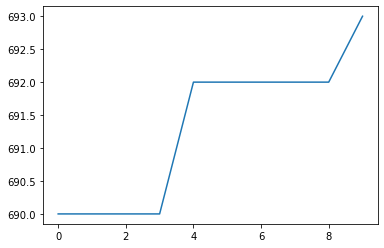

In [5]:
plt.plot(dataset['Anchovy_pizza'][:10])

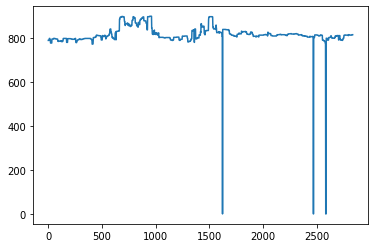

In [6]:
plt.plot(dataset['Pineapple_pizza'])

I'm going to pick Anchovy and Meat pizza since they have pretty similar prices, although the meat pizza varries wildly in price. I believe this is due to double xp events.

In [7]:
train = dataset['Anchovy_pizza'][:2800]
test = dataset['Pineapple_pizza'][:2800]

In [8]:
train = np.array(train)
train = np.reshape(train, (-1, 1))

In [9]:
scaled_data = scaler.fit_transform(train)

In [10]:
x_train, y_train = [], []
for i in range(60,2800):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

Before we feed our data into a network note that our LSTM requires 3d array in the format ` [data_size, amount of timesteps, features]`, otherwise we will run into a very common bug called dimension shuffling. 

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [12]:
x_train.shape

(2740, 60, 1)

###Building our model

This is a very simple model but let's walk through it. Firstly we declare a sequential network and name it model. We can now specify our layers. Firstly we start out with an LSTM layer of size 64, we have return_sequences set to true because we will be feeding our data into another LSTM. The next LSTM has 32 units. And lastly we have a Dense head for the network which gives us our price prediction.

*Each LSTM unit is a single neuron in the whole LSTM layer, each unit has hidden cells that are the length of our sequences.*

In [13]:
model = Sequential()
model.add(LSTM(units=64, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=32))
model.add(Dense(16))
model.add(Dense(1))

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=['accuracy'])
model.fit(x_train,y_train,epochs=10,batch_size=16)

Epoch 1/3
172/172 [==============================] - 24s 98ms/step - loss: 0.0801 - accuracy: 0.0084
Epoch 2/3
172/172 [==============================] - 12s 67ms/step - loss: 0.0032 - accuracy: 0.0099
Epoch 3/3
172/172 [==============================] - 7s 44ms/step - loss: 0.0032 - accuracy: 0.0099


###Plotting Predictions

To predict how well we perform we will create a test dataset and an actual price dataset. We will feed the test dataset into our model and predict the price for the next day. Then we will plot them both to compare.

In [15]:
def ComparePredictions(item_name):
  data = dataset[item_name][:2800]
  
  #scale test_x data
  test = np.array(data)
  test = np.reshape(test, (-1,1))
  test = scaler.transform(test)

  #trim test_y data
  data = data[160:2800]
  data = data.reset_index()
  data = data.drop('index', axis=1)

  #create predictions
  X_test = []
  for i in range(60,test.shape[0]):
    X_test.append(test[i-60:i,0])
  X_test = np.array(X_test)
  X_test = X_test[100:]
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  closing_price = model.predict(X_test)
  closing_price = scaler.inverse_transform(closing_price)

  #plot 
  plt.figure(figsize=(20,10))
  plt.plot(closing_price, label='prediction')
  plt.plot(data, label='actual')
  plt.legend(loc='upper left')
  plt.show()

####Pineapple Pizza Predictions

83/83 [==============================] - 2s 15ms/step


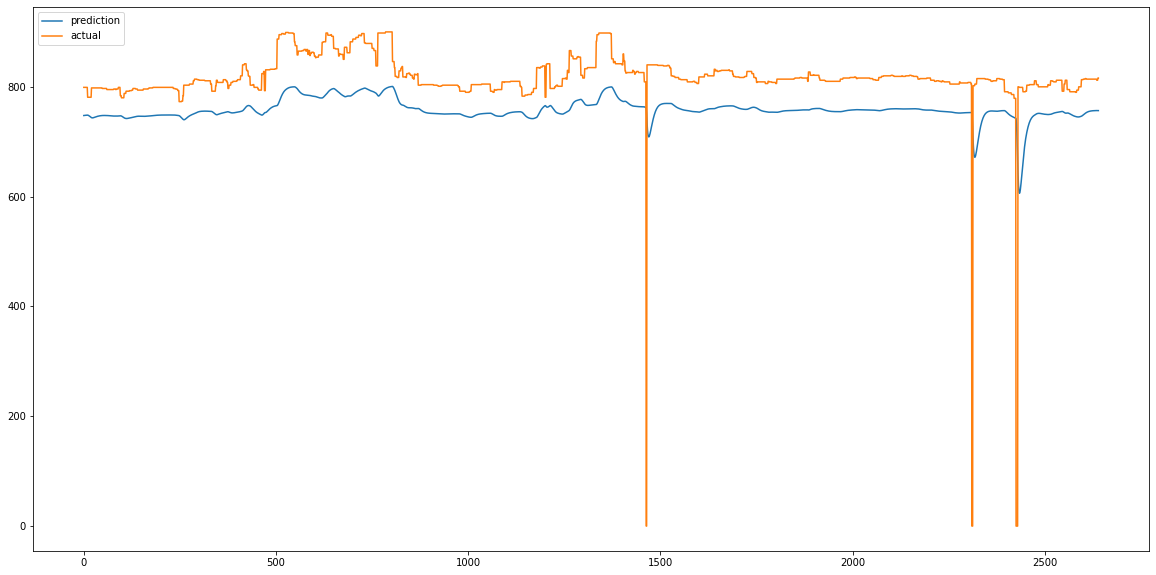

In [16]:
ComparePredictions("Pineapple_pizza")

####Meat Pizza Predictions

83/83 [==============================] - 1s 15ms/step


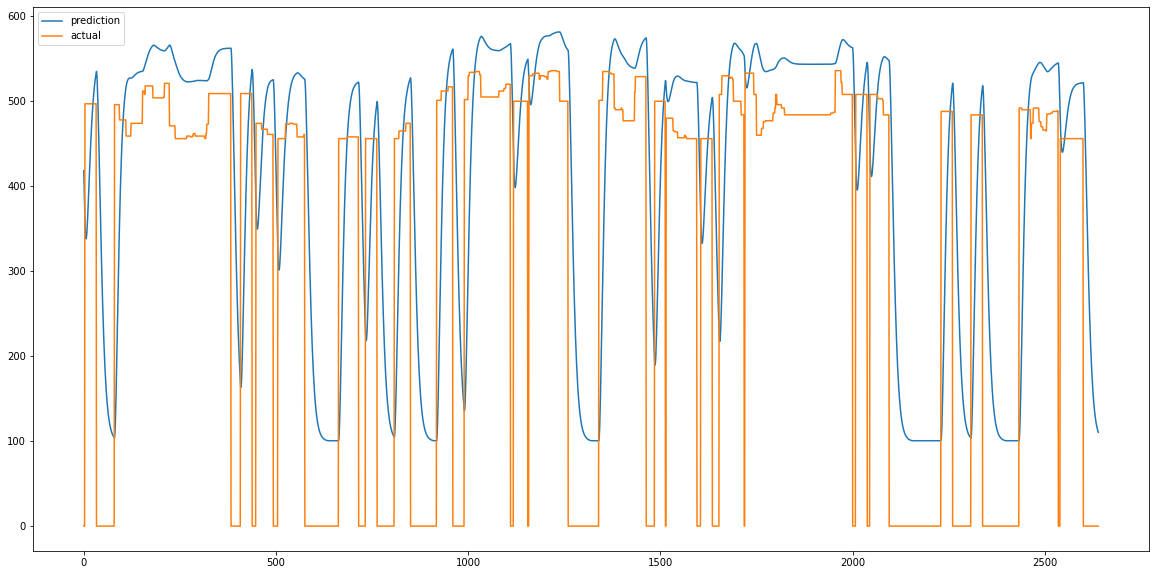

In [17]:
ComparePredictions("Meat_pizza")

####You Try

83/83 [==============================] - 1s 15ms/step


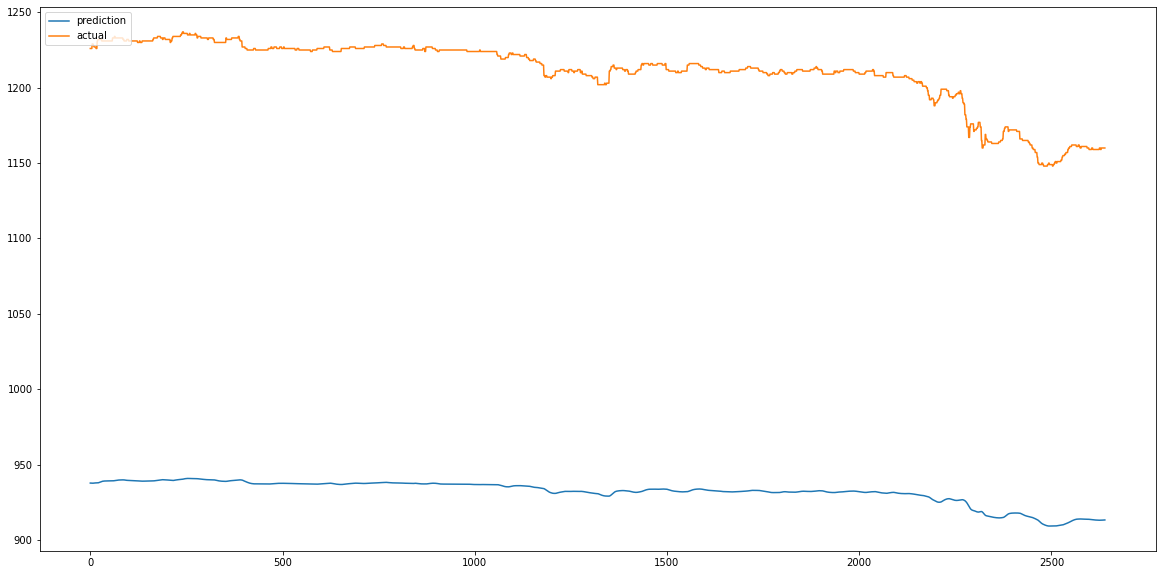

In [18]:
ComparePredictions("Shark")